<a href="https://colab.research.google.com/github/Pai026/DermaCamModel/blob/main/case_studyWIP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf
from keras.layers import Dense
import keras

In [ ]:
dataDir = "/content/drive/My Drive/Training"
skinDiseaseTypes= [ item for item in os.listdir(dataDir) if os.path.isdir(os.path.join(dataDir, item)) ]
trainDir = os.path.join(dataDir)
print(len(skinDiseaseTypes))

7


In [ ]:
trainData = []
for diseaseID, sp in enumerate(skinDiseaseTypes):
    for file in os.listdir(os.path.join(trainDir, sp)):
        trainData.append(['{}/{}'.format(sp, file), diseaseID, sp])
        
train = pd.DataFrame(trainData, columns=['File', 'DiseaseId','Disease Type'])
train.tail()

,File,DiseaseId,Disease Type
254,blackhead/b67.jpg,6,blackhead
255,blackhead/b59.jpg,6,blackhead
256,blackhead/b70.jpg,6,blackhead
257,blackhead/b62.jfif,6,blackhead
258,blackhead/b65.jpg,6,blackhead


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) 
train.head()

,File,DiseaseId,Disease Type
0,acne fulminans/f69.JPG,1,acne fulminans
1,acne fulminans/f46.JPG,1,acne fulminans
2,fungal acne/fu59.JPG,0,fungal acne
3,acne nodules/n36.JPG,2,acne nodules
4,rosacea/r73.jpg,3,rosacea


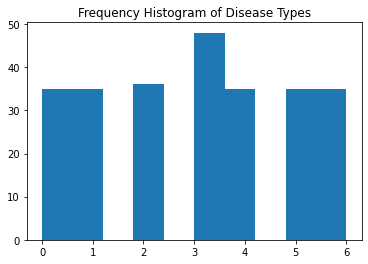

<Figure size 864x864 with 0 Axes>

In [ ]:
plt.hist(train['DiseaseId'])
plt.title('Frequency Histogram of Disease Types')
plt.figure(figsize=(12, 12))
plt.show()

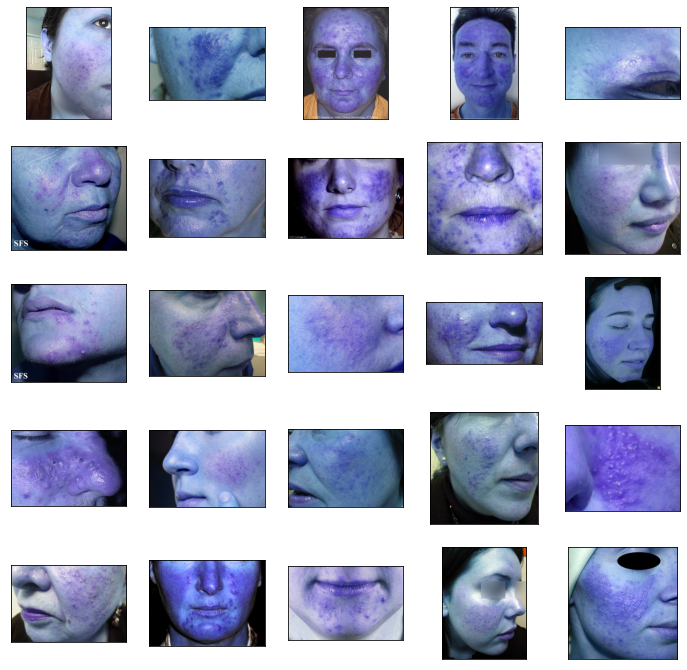

In [ ]:
def plot_defects(skinDiseaseTypes, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    flowerFiles = train['File'][train['Disease Type'] == skinDiseaseTypes].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            imagePath = os.path.join(dataDir, flowerFiles[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(imagePath))
            n += 1
# Displays first n images of class from training set
plot_defects('rosacea', 5, 5)

In [ ]:
imageSize = 64

def read_image(filePath):
    return cv2.imread(os.path.join(dataDir, filePath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, imageSize):
    return cv2.resize(image.copy(), imageSize, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], imageSize, imageSize, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (imageSize, imageSize))

X_Train = X_train / 255
print('Train Shape: {}'.format(X_Train.shape))

259it [00:59,  4.34it/s]

Train Shape: (259, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseId'].values
Y_train = to_categorical(Y_train, num_classes=7)

In [ ]:
batchSize = 64

X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)
print(len(X_train))
print(len(Y_train))
print(len(X_val))
print(len(Y_val))

207
207
52
52


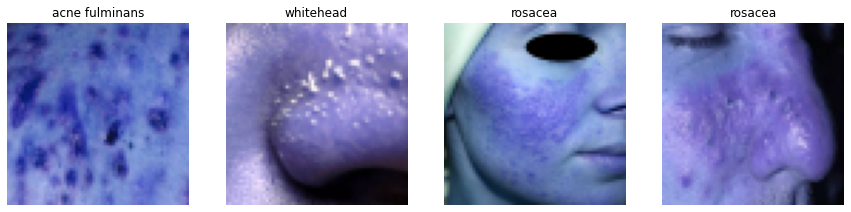

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(skinDiseaseTypes[np.argmax(Y_train[i])])

In [ ]:
cnnmodel = models.Sequential()
cnnmodel.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(64, 64, 3)))
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(layers.Flatten())
cnnmodel.add(layers.Dropout(0.4))
cnnmodel.add(layers.Dense(512, activation='relu'))
cnnmodel.add(layers.Dense(7, activation='softmax'))

cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [ ]:
cnnmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,MaxPooling2D

image_dir = "/content/drive/My Drive/Training"
data_generator = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=30, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest"
                                   )

train_generator = data_generator.flow_from_directory(
        image_dir,
        subset="training",
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

#print(train_generator)
validation_generator = data_generator.flow_from_directory(
        image_dir,
        subset="validation",
        target_size=(64,64),
        class_mode='categorical')

Found 183 images belonging to 7 classes.
Found 44 images belonging to 7 classes.


In [ ]:
history = cnnmodel.fit(
          train_generator,
          epochs=20,
          validation_data=validation_generator,
          batch_size=batchSize,
          verbose=1)

Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 1.9532 - acc: 0.1725

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


6/6 [==============================] - 35s 427ms/step - loss: 1.9521 - acc: 0.1713 - val_loss: 1.9053 - val_acc: 0.1591
Epoch 2/20
6/6 [==============================] - 2s 327ms/step - loss: 1.9235 - acc: 0.1542 - val_loss: 1.8850 - val_acc: 0.1818
Epoch 3/20
6/6 [==============================] - 2s 255ms/step - loss: 1.8791 - acc: 0.2284 - val_loss: 1.8936 - val_acc: 0.1591
Epoch 4/20
6/6 [==============================] - 2s 304ms/step - loss: 1.8924 - acc: 0.1798 - val_loss: 1.8794 - val_acc: 0.1818
Epoch 5/20
6/6 [==============================] - 2s 319ms/step - loss: 1.8808 - acc: 0.2133 - val_loss: 1.8734 - val_acc: 0.1818
Epoch 6/20
6/6 [==============================] - 2s 327ms/step - loss: 1.8860 - acc: 0.2085 - val_loss: 1.8643 - val_acc: 0.2273
Epoch 7/20
6/6 [==============================] - 2s 333ms/step - loss: 1.8702 - acc: 0.2136 - val_loss: 1.8568 - val_acc: 0.2727
Epoch 8/20
6/6 [==============================] - 2s 301ms/step - loss: 1.8798 - acc: 0.1955 - val_l

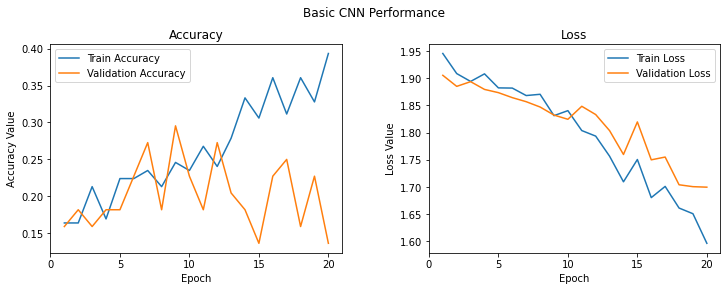

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
print("Max Accuracy = "+str(max(history.history["acc"])))
print("Max Validation Accuracy = "+str(max(history.history["val_acc"])))

Max Accuracy = 0.39344263076782227
Max Validation Accuracy = 0.2954545319080353


In [ ]:
from keras.applications import vgg16
from keras.models import Sequential
import keras

new_model1 = Sequential()
new_model1.add(vgg16.VGG16(include_top=False, 
                          pooling='avg', 
                          weights='imagenet', 
                         )
)

new_model1.add(Dense(7,activation='softmax'))

new_model1.layers[0].trainable = False
new_model1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
new_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 14,718,279
Trainable params: 3,591
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = new_model1.fit(
          train_generator,
    validation_data=validation_generator,
          epochs=20,
          batch_size=batchSize,
          verbose=1)

Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 1.9157 - accuracy: 0.2833

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


6/6 [==============================] - 4s 569ms/step - loss: 1.9166 - accuracy: 0.2796 - val_loss: 1.8525 - val_accuracy: 0.2955
Epoch 2/20
6/6 [==============================] - 2s 350ms/step - loss: 1.8093 - accuracy: 0.3067 - val_loss: 1.8166 - val_accuracy: 0.3636
Epoch 3/20
6/6 [==============================] - 2s 302ms/step - loss: 1.7970 - accuracy: 0.2831 - val_loss: 1.8087 - val_accuracy: 0.2955
Epoch 4/20
6/6 [==============================] - 2s 350ms/step - loss: 1.7372 - accuracy: 0.3446 - val_loss: 1.7643 - val_accuracy: 0.3636
Epoch 5/20
6/6 [==============================] - 2s 347ms/step - loss: 1.7681 - accuracy: 0.3626 - val_loss: 1.8004 - val_accuracy: 0.2273
Epoch 6/20
6/6 [==============================] - 2s 338ms/step - loss: 1.6894 - accuracy: 0.4649 - val_loss: 1.7395 - val_accuracy: 0.3409
Epoch 7/20
6/6 [==============================] - 2s 345ms/step - loss: 1.6901 - accuracy: 0.3820 - val_loss: 1.7372 - val_accuracy: 0.3409
Epoch 8/20
6/6 [===============

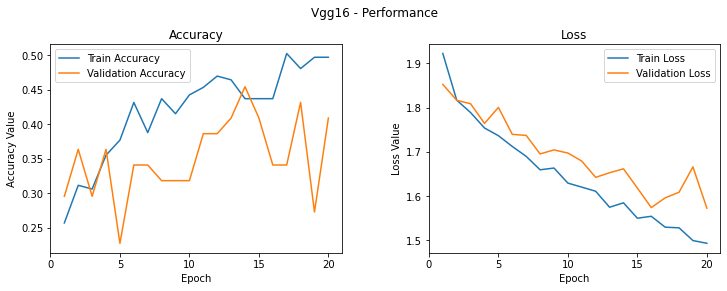

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Vgg16 - Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
print("Max Accuracy = "+str(max(history.history["accuracy"])))
print("Max Validation Accuracy = "+str(max(history.history["val_accuracy"])))

Max Accuracy = 0.5027322173118591
Max Validation Accuracy = 0.4545454680919647


In [ ]:
import tensorflow as tf
from keras.layers import Dense
from keras import Sequential
from keras.applications import mobilenet


mobile_net_model = Sequential()
mobile_net_model.add(mobilenet.MobileNet(include_top=False, pooling='avg', weights='imagenet'))
mobile_net_model.add(Dense(7, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
mobile_net_model.layers[0].trainable = False

mobile_net_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
histt=mobile_net_model.fit(train_generator,
    validation_data=validation_generator, batch_size= batchSize, epochs=20, verbose=1)

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 2.2580 - accuracy: 0.1551

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


6/6 [==============================] - 4s 444ms/step - loss: 2.2367 - accuracy: 0.1618 - val_loss: 2.1552 - val_accuracy: 0.2273
Epoch 2/20
6/6 [==============================] - 2s 326ms/step - loss: 1.9859 - accuracy: 0.2110 - val_loss: 2.1082 - val_accuracy: 0.2273
Epoch 3/20
6/6 [==============================] - 2s 311ms/step - loss: 1.7786 - accuracy: 0.2752 - val_loss: 1.9733 - val_accuracy: 0.2500
Epoch 4/20
6/6 [==============================] - 2s 319ms/step - loss: 1.8396 - accuracy: 0.3116 - val_loss: 1.9825 - val_accuracy: 0.2273
Epoch 5/20
6/6 [==============================] - 2s 298ms/step - loss: 1.6730 - accuracy: 0.3528 - val_loss: 2.0850 - val_accuracy: 0.2045
Epoch 6/20
6/6 [==============================] - 2s 323ms/step - loss: 1.6161 - accuracy: 0.3495 - val_loss: 1.9231 - val_accuracy: 0.2500
Epoch 7/20
6/6 [==============================] - 2s 323ms/step - loss: 1.4878 - accuracy: 0.3781 - val_loss: 1.8898 - val_accuracy: 0.2727
Epoch 8/20
6/6 [===============

In [ ]:
mobile_net_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 7175      
Total params: 3,236,039
Trainable params: 7,175
Non-trainable params: 3,228,864
_________________________________________________________________


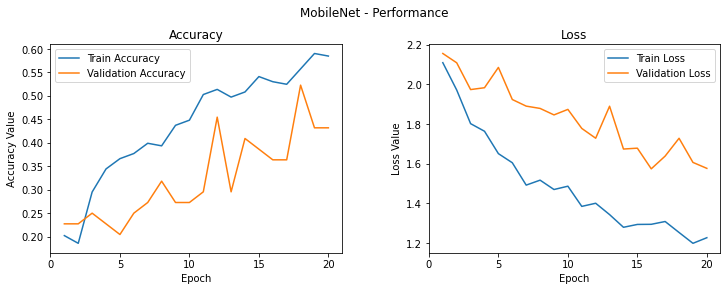

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MobileNet - Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, histt.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, histt.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, histt.history['loss'], label='Train Loss')
ax2.plot(epoch_list, histt.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
print("Max Accuracy = "+str(max(histt.history["accuracy"])))
print("Max Validation Accuracy = "+str(max(histt.history["val_accuracy"])))

Max Accuracy = 0.5901639461517334
Max Validation Accuracy = 0.5227272510528564


In [ ]:
from keras import applications
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (64,64,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(7, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
model.layers[0].trainable = False
model.compile(optimizer= optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnetHist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    batch_size = batchSize,
    verbose=1
)

Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 3.5497 - accuracy: 0.1807

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


6/6 [==============================] - 14s 725ms/step - loss: 3.5415 - accuracy: 0.1822 - val_loss: 2.6860 - val_accuracy: 0.1364
Epoch 2/20
6/6 [==============================] - 2s 323ms/step - loss: 3.0134 - accuracy: 0.2380 - val_loss: 3.0139 - val_accuracy: 0.1364
Epoch 3/20
6/6 [==============================] - 2s 321ms/step - loss: 2.5744 - accuracy: 0.3353 - val_loss: 4.3175 - val_accuracy: 0.1364
Epoch 4/20
6/6 [==============================] - 2s 361ms/step - loss: 2.1315 - accuracy: 0.4544 - val_loss: 7.5210 - val_accuracy: 0.1364
Epoch 5/20
6/6 [==============================] - 2s 362ms/step - loss: 1.8744 - accuracy: 0.4293 - val_loss: 7.9152 - val_accuracy: 0.1364
Epoch 6/20
6/6 [==============================] - 2s 356ms/step - loss: 1.3890 - accuracy: 0.5638 - val_loss: 7.4401 - val_accuracy: 0.1364
Epoch 7/20
6/6 [==============================] - 2s 369ms/step - loss: 1.5071 - accuracy: 0.5893 - val_loss: 7.3058 - val_accuracy: 0.1591
Epoch 8/20
6/6 [==============

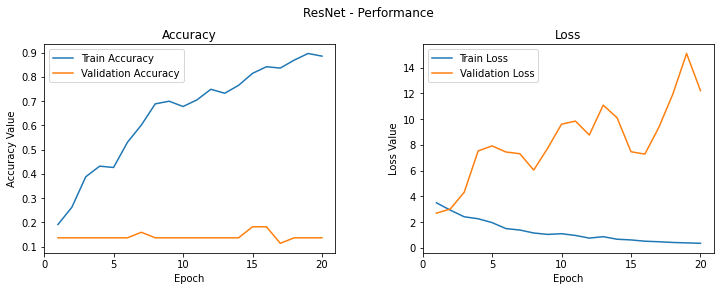

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet - Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, resnetHist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, resnetHist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, resnetHist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, resnetHist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
print("Max Accuracy = "+str(max(resnetHist.history["accuracy"])))
print("Max Validation Accuracy = "+str(max(resnetHist.history["val_accuracy"])))

Max Accuracy = 0.8961748480796814
Max Validation Accuracy = 0.1818181872367859


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(64, 64, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(7,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    batch_size = batchSize,
    verbose=1
)

29089792/29084464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
____________________________________________________________

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


6/6 [==============================] - 18s 1s/step - loss: 3.1095 - accuracy: 0.0871 - val_loss: 2.3477 - val_accuracy: 0.1136
Epoch 2/20
6/6 [==============================] - 2s 320ms/step - loss: 2.7975 - accuracy: 0.2638 - val_loss: 2.4435 - val_accuracy: 0.1136
Epoch 3/20
6/6 [==============================] - 2s 366ms/step - loss: 2.6301 - accuracy: 0.2101 - val_loss: 2.3224 - val_accuracy: 0.0227
Epoch 4/20
6/6 [==============================] - 2s 371ms/step - loss: 2.4505 - accuracy: 0.2481 - val_loss: 2.3178 - val_accuracy: 0.0909
Epoch 5/20
6/6 [==============================] - 2s 335ms/step - loss: 2.3442 - accuracy: 0.2961 - val_loss: 2.4245 - val_accuracy: 0.2500
Epoch 6/20
6/6 [==============================] - 2s 378ms/step - loss: 2.4368 - accuracy: 0.2971 - val_loss: 2.4806 - val_accuracy: 0.1591
Epoch 7/20
6/6 [==============================] - 2s 373ms/step - loss: 2.1904 - accuracy: 0.2883 - val_loss: 2.3777 - val_accuracy: 0.2273
Epoch 8/20
6/6 [=================

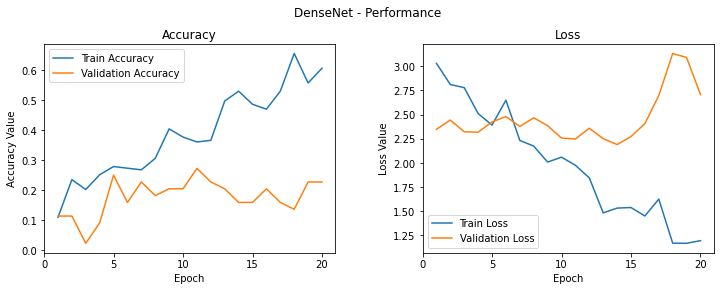

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('DenseNet - Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
print("Max Accuracy = "+str(max(hist.history["accuracy"])))
print("Max Validation Accuracy = "+str(max(hist.history["val_accuracy"])))

Max Accuracy = 0.6557376980781555
Max Validation Accuracy = 0.27272728085517883
